In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
#set num_filter to be about 10 to 20% of the original #variables
num_filter = 285
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 80347] # remove the last two months as the out-of-time data (OOT)
    #df = df[df.index >= 38511] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables.csv size is (96397, 1424)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
candidate_variables.csv                         variable  filter score
0                          Fraud      1.000000
421            card_zip3_total_7      0.695413
430           card_zip3_total_14      0.691942
412            card_zip3_total_3      0.683707
229             card_zip_total_7      0.682216
165           card_merch_total_7      0.678745
174          card_merch_total_14      0.674922
439           card_zip3_total_30      0.673911
220             card_zip_total_3      0.673199
156           card_merch_total_3      0.671739
238            card_zip_total_14      0.671293
494      Card_Merchdesc_total_14      0.669310
485       Card_Merchdesc_total_7      0.668169
247            card_zip_total_30      0.667759
622  Card_Merchnum_desc_total_14      0.665984
613   Card_Merchnum_desc_total_7      0.662528
403            card_zip3_total_1      0.662042
4

<timed exec>:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


CPU times: user 19.7 s, sys: 4.42 s, total: 24.1 s
Wall time: 25.3 s


In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,card_zip3_total_7,0.695413
2,card_zip3_total_14,0.691942
3,card_zip3_total_3,0.683707
4,card_zip_total_7,0.682216
5,card_merch_total_7,0.678745
6,card_merch_total_14,0.674922
7,card_zip3_total_30,0.673911
8,card_zip_total_3,0.673199
9,card_merch_total_3,0.671739


In [6]:
filter_score.tail(10)

,variable,filter score
1414,Merchnum_unique_count_for_zip3_3,0.000748
1415,card_merch_unique_count_for_zip3_7,0.000720
1416,Card_Merchdesc_unique_count_for_zip3_1,0.000669
1417,Card_Merchnum_desc_unique_count_for_zip3_7,0.000606
1418,card_merch_unique_count_for_zip3_3,0.000593
1419,Card_Merchnum_desc_unique_count_for_zip3_3,0.000480
1420,card_merch_unique_count_for_zip3_1,0.000467
1421,Card_Merchnum_desc_unique_count_for_zip3_1,0.000391
1422,Merchnum_unique_count_for_zip3_14,0.000347
1423,card_merch_unique_count_for_Cardnum_1,0.000000


In [7]:
filter_score.shape

(1424, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip3_total_7', 'card_zip3_total_14', 'card_zip3_total_3', 'card_zip_total_7', 'card_merch_total_7', 'card_merch_total_14', 'card_zip3_total_30', 'card_zip_total_3', 'card_merch_total_3', 'card_zip_total_14', 'Card_Merchdesc_total_14', 'Card_Merchdesc_total_7', 'card_zip_total_30', 'Card_Merchnum_desc_total_14', 'Card_Merchnum_desc_total_7', 'card_zip3_total_1', 'card_zip3_max_7', 'Card_Merchdesc_total_30', 'card_zip3_total_60', 'card_merch_total_30', 'card_zip_total_60', 'Card_Merchdesc_total_60', 'card_zip_total_1', 'Card_Merchnum_desc_total_30', 'Card_Merchdesc_total_3', 'card_zip3_max_14', 'Card_Merchdesc_max_14', 'card_merch_total_1', 'Card_Merchnum_desc_total_60', 'card_zip_max_14', 'card_zip_max_7', 'card_merch_total_60', 'Card_Merchdesc_max_7', 'Card_Merchnum_desc_max_14', 'card_zip3_max_3', 'Card_Merchdesc_max_30', 'card_merch_max_14', 'Card_Merchnum_desc_total_3', 'card_zip_max_30', 'Card_Merchnum_desc_max_30', 'Card_Merchnum_desc_max_7', 'card_merch_max_3

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip3_total_7,card_zip3_total_14,card_zip3_total_3,card_zip_total_7,card_merch_total_7,card_merch_total_14,card_zip3_total_30,card_zip_total_3,card_merch_total_3,card_zip_total_14,...,zip3_variability_med_3,merch_zip_med_30,Merchnum_med_30,Merchnum_avg_60,zip3_actual/med_14,merch_zip_avg_60,Merchnum_desc_variability_med_30,Merchnum_desc_actual/avg_60,Merchnum_variability_avg_30,zip3_avg_3
Recnum,,,,,,,,,,,,,,,,,,,,,
1,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,0.0,3.62,3.62,3.62,1.0,3.62,0.0,1.0,0.0,3.62
2,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,0.0,31.42,31.42,31.42,1.0,31.42,0.0,1.0,0.0,31.42
3,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,0.0,178.49,178.49,178.49,1.0,178.49,0.0,1.0,0.0,178.49
4,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,0.0,3.62,3.62,3.62,1.0,3.62,0.0,1.0,0.0,3.62
5,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,7.24,...,0.0,3.62,3.62,3.62,1.0,3.62,0.0,1.0,0.0,3.62


In [10]:
df_keep.shape

(80023, 285)

In [11]:
Y.head()

,Fraud
Recnum,
1,0
2,0
3,0
4,0
5,0


In [12]:
Y = Y.values
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:01:13.841643


In [15]:
print(X.shape,Y.shape)

(80023, 285) (80023, 1)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [18]:
def fdr(classifier, x, y, cutoff=detect_rate):

# Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    
        y_prob = y_prob[:, -1:]   
    num_fraud = len(y[y == 1])    
    
# sort the probablity list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
    
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [20]:
from catboost import CatBoostClassifier

/Users/nithyaananthapadmanabhagorur/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [23]:
from sklearn.neural_network import MLPClassifier

In [21]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 


nfeatures = len(X.columns)

clf = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)
#forward selection
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1)
#sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

/Users/nithyaananthapadmanabhagorur/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nithyaananthapadmanabhagorur/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nithyaananthapadmanabhagorur/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nithyaananthapadmanabhagorur/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWar

CPU times: user 15.5 s, sys: 3.73 s, total: 19.2 s
Wall time: 15min 22s


SequentialFeatureSelector(cv=3,
                          estimator=<catboost.core.CatBoostClassifier object at 0x7f78cc651520>,
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x7f78b8d855e0>)

In [22]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:20:16.622983


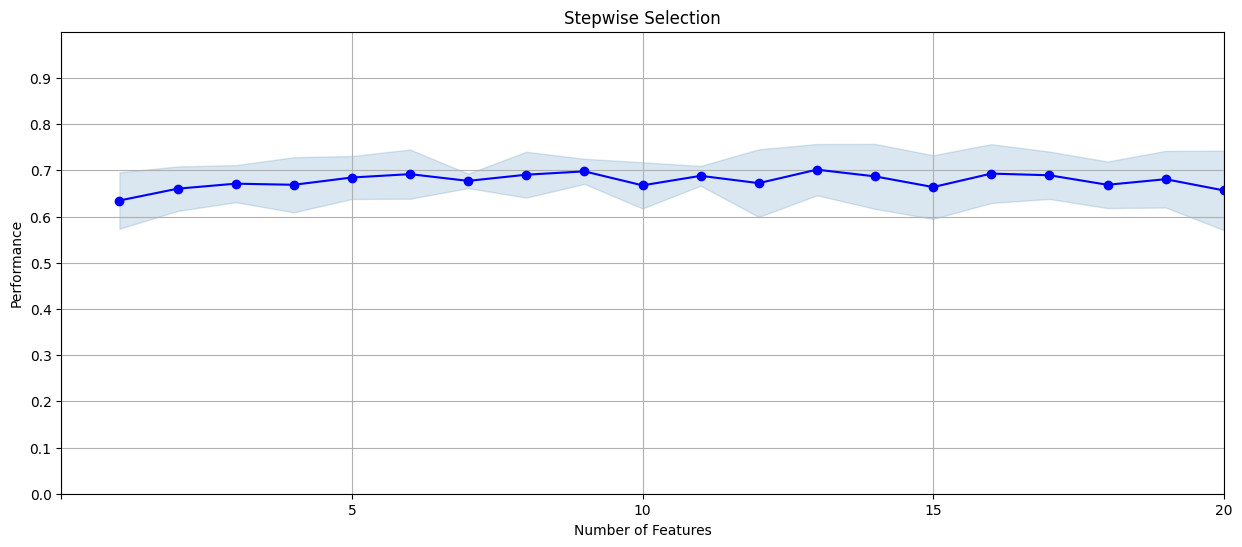

In [23]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [24]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [25]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# You might also need this following line. It converts a list to a string
        #         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [62]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(0,)","[0.610909090909091, 0.6605839416058394, 0.7054...",0.658983,"(card_zip3_total_7,)",0.086896,0.038615,0.027305,1.0,card_zip3_total_7
2,"(0, 42)","[0.610909090909091, 0.6605839416058394, 0.7018...",0.65777,"(card_zip3_total_7, card_merch_max_7)",0.083637,0.037167,0.026281,2.0,[card_merch_max_7]
3,"(0, 42, 150)","[0.6254545454545455, 0.5912408759124088, 0.665...",0.627383,"(card_zip3_total_7, card_merch_max_7, Cardnum_...",0.068249,0.030328,0.021445,3.0,[Cardnum_total_0]
4,"(0, 42, 150, 246)","[0.5927272727272728, 0.5912408759124088, 0.676...",0.620111,"(card_zip3_total_7, card_merch_max_7, Cardnum_...",0.089522,0.039782,0.02813,4.0,[zip3_avg_1]
5,"(0, 42, 150, 217, 246)","[0.6145454545454545, 0.5985401459854015, 0.578...",0.597089,"(card_zip3_total_7, card_merch_max_7, Cardnum_...",0.033487,0.014881,0.010522,5.0,[Merchnum_desc_avg_14]
6,"(0, 42, 63, 150, 217, 246)","[0.6254545454545455, 0.4562043795620438, 0.767...",0.616311,"(card_zip3_total_7, card_merch_max_7, Merchnum...",0.286147,0.127158,0.089914,6.0,[Merchnum_desc_total_1]
7,"(0, 42, 63, 150, 201, 217, 246)","[0.5927272727272728, 0.572992700729927, 0.5854...",0.583725,"(card_zip3_total_7, card_merch_max_7, Merchnum...",0.018338,0.008149,0.005762,7.0,[zip3_avg_0]
8,"(0, 42, 63, 73, 150, 201, 217, 246)","[0.56, 0.6021897810218978, 0.7090909090909091]",0.62376,"(card_zip3_total_7, card_merch_max_7, Merchnum...",0.141204,0.062748,0.04437,8.0,[Card_Merchnum_desc_total_0]
9,"(0, 28, 42, 63, 73, 150, 201, 217, 246)","[0.48, 0.6131386861313869, 0.6290909090909091]",0.574077,"(card_zip3_total_7, Card_Merchnum_desc_total_6...",0.150412,0.06684,0.047263,9.0,[Card_Merchnum_desc_total_60]
10,"(0, 28, 42, 63, 73, 150, 201, 210, 217, 246)","[0.6654545454545454, 0.5291970802919708, 0.709...",0.634581,"(card_zip3_total_7, Card_Merchnum_desc_total_6...",0.172414,0.076617,0.054177,10.0,[Cardnum_max_60]


In [26]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [27]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1             Card_Merchdesc_total_7
2                 [card_zip3_max_14]
3               [card_merch_total_3]
4            [Merchnum_desc_total_3]
5               [card_zip3_total_14]
6                    [Cardnum_avg_3]
7          [Card_Merchdesc_total_60]
8              [card_merch_total_14]
9                [card_zip3_total_7]
10               [card_zip_total_14]
11       [Card_Merchnum_desc_med_30]
12           [Merchnum_desc_total_1]
13         [zip3_variability_med_14]
14              [zip3_actual/max_30]
15     [Card_Merchnum_desc_total_60]
16               [card_zip3_total_3]
17    [Cardnum_total_amount_1_by_60]
18          [Card_Merchdesc_total_3]
19                [card_zip_total_7]
20           [Card_Merchdesc_max_14]
Name: variable name, dtype: object

In [28]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
card_zip3_total_7,0.695413
card_zip3_total_14,0.691942
card_zip3_total_3,0.683707
card_zip_total_7,0.682216
card_merch_total_7,0.678745
...,...
Card_Merchnum_desc_unique_count_for_zip3_3,0.000480
card_merch_unique_count_for_zip3_1,0.000467
Card_Merchnum_desc_unique_count_for_zip3_1,0.000391


In [38]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
#vars_keep_sorted.set_index(tuple(vars_keep_list), drop=True, inplace=True)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()



""
variable
Card_Merchdesc_total_7
[card_zip3_max_14]
[card_merch_total_3]
[Merchnum_desc_total_3]
[card_zip3_total_14]


In [30]:
filter_score.empty

False

In [31]:
filter_score.columns

Index(['filter score'], dtype='object')

In [33]:
vars_keep_sorted.columns

Index([], dtype='object')

In [34]:
filter_score.index

Index(['card_zip3_total_7', 'card_zip3_total_14', 'card_zip3_total_3',
       'card_zip_total_7', 'card_merch_total_7', 'card_merch_total_14',
       'card_zip3_total_30', 'card_zip_total_3', 'card_merch_total_3',
       'card_zip_total_14',
       ...
       'Merchnum_unique_count_for_zip3_3',
       'card_merch_unique_count_for_zip3_7',
       'Card_Merchdesc_unique_count_for_zip3_1',
       'Card_Merchnum_desc_unique_count_for_zip3_7',
       'card_merch_unique_count_for_zip3_3',
       'Card_Merchnum_desc_unique_count_for_zip3_3',
       'card_merch_unique_count_for_zip3_1',
       'Card_Merchnum_desc_unique_count_for_zip3_1',
       'Merchnum_unique_count_for_zip3_14',
       'card_merch_unique_count_for_Cardnum_1'],
      dtype='object', name='variable', length=1423)

In [35]:
vars_keep_sorted.index

Index([        'Card_Merchdesc_total_7',             ['card_zip3_max_14'],
                 ['card_merch_total_3'],        ['Merchnum_desc_total_3'],
                 ['card_zip3_total_14'],                ['Cardnum_avg_3'],
            ['Card_Merchdesc_total_60'],          ['card_merch_total_14'],
                  ['card_zip3_total_7'],            ['card_zip_total_14'],
          ['Card_Merchnum_desc_med_30'],        ['Merchnum_desc_total_1'],
            ['zip3_variability_med_14'],           ['zip3_actual/max_30'],
        ['Card_Merchnum_desc_total_60'],            ['card_zip3_total_3'],
       ['Cardnum_total_amount_1_by_60'],       ['Card_Merchdesc_total_3'],
                   ['card_zip_total_7'],        ['Card_Merchdesc_max_14']],
      dtype='object', name='variable')

In [68]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable
0,1,card_zip3_total_7
1,2,[card_merch_max_7]
2,3,[Cardnum_total_0]
3,4,[zip3_avg_1]
4,5,[Merchnum_desc_avg_14]
5,6,[Merchnum_desc_total_1]
6,7,[zip3_avg_0]
7,8,[Card_Merchnum_desc_total_0]
8,9,[Card_Merchnum_desc_total_60]
9,10,[Cardnum_max_60]


In [69]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_zip3_total_7',
 ['card_merch_max_7'],
 ['Cardnum_total_0'],
 ['zip3_avg_1'],
 ['Merchnum_desc_avg_14'],
 ['Merchnum_desc_total_1'],
 ['zip3_avg_0'],
 ['Card_Merchnum_desc_total_0'],
 ['Card_Merchnum_desc_total_60'],
 ['Cardnum_max_60'],
 ['zip3_actual/max_60'],
 ['card_merch_avg_30'],
 ['Merchnum_desc_avg_30'],
 ['zip3_actual/avg_60'],
 ['Cardnum_avg_14'],
 ['Card_Merchnum_desc_avg_7'],
 ['Card_Merchdesc_avg_60'],
 ['Card_Merchdesc_avg_1'],
 ['Merchnum_avg_14'],
 ['Cardnum_med_7'],
 'Recnum',
 'Fraud']

In [70]:
filter_score

,filter score
variable,
card_zip3_total_7,0.695413
card_zip3_total_14,0.691942
card_zip3_total_3,0.683707
card_zip_total_7,0.682216
card_merch_total_7,0.678745
...,...
Card_Merchnum_desc_unique_count_for_zip3_3,0.000480
card_merch_unique_count_for_zip3_1,0.000467
Card_Merchnum_desc_unique_count_for_zip3_1,0.000391


In [71]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 11.4 s, sys: 2.28 s, total: 13.6 s
Wall time: 16.8 s


(96397, 1424)

In [ ]:
df_keep.to_csv('vars_final.csv',index=False)

In [ ]:
print("duration: ", dt.datetime.now() - start_time)